## Рекомендация тарифов

Компания `Мегалайн`, федеральный оператор сотовой связи, установила: многие клиенты пользуются архивными тарифными планами. Оператор мобильной связи хочет выстроить систему, которая предлагает клиентам на выбор два тарифных плана: *Смарт* или *Ультра*, в зависимости от их поведения. Чтобы пользователям сотовой связи предлагали подходящий тарифный план, нужна чёткая система рекомендации тарифов.

**Задача проекта** — построить модель для задачи классификации с максимальном большим значением *accuracy*, которая подберёт подходящий тариф. 

### Шаг 1. Изучение данных из файла

In [74]:
# импорт библиотек и методов
import pandas as pd
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyClassifier
import seaborn as sns
import matplotlib.pyplot as plt

> Данные о месячном поведении клиентов, которые перешли на тарифы *Смарт* и *Ультра* находятся в файле `users_behavior.csv`

In [75]:
# чтение файла и вывод первых пяти строк
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


**Исходные данные:**

Таблица `users_behavior`

* *calls* — количество звонков, совершенных польователем
* *minutes* — суммарная длительность звонков в минутах
* *messages* — количество отправленных сообщений
* *mb_used* — объём потраченного интернет-трафика (в мегабайтах)
* *is_ultra* — тариф пользователя (1 — тариф *Ультра*, 0 — тариф *Смарт*)

**Описание тарифов**:

Тариф «Смарт»
* *Ежемесячная плата:* 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* *Стоимость услуг сверх тарифного пакета:* 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»
* *Ежемесячная плата:* 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* *Стоимость услуг сверх тарифного пакета*: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

>Примечание:
>«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он >длился всего 1 секунду, будет засчитан как 1 минута.
>Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент >использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

In [76]:
# получение общей информации о данных в таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [77]:
# получение сводки числовых значений данных в таблице
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Проанализируем полученную информацию. Таблица содержит 5 колонок с типами данных:
* `float64`
* `int64`

В названиях колонок использован стиль наименования переменных *lower_case_with_underscores*. Нарушения стиля названия имен отсутствуют. Количество значений в стоблцах таблицы не различается. Минимальные нулевые значения в колонках могут говорить о том, что клиент сотовой связи не пользовался данными видами услуг.

Поскольку мы пользуемся данными из проекта `Статистический анализ данных`, предобработка информации не поданобится.

**Вывод:**

Данные из файла изучены. Предобработка не требуется.

### Шаг 2. Разбиение данных на выборки

Разобьём данные на три части: *обучающую*, *валидационную* и *тестовую*. Исходные данные разобьём в соотношении 3:1:1, т.е. обучающая выборка составит 60% данных, валидационная и тестовая — по 20% каждая.

Для начала разделим исходные данные на признаки (все, кроме колонки `is_ultra`) и целевой признак (колонка `is_ultra`). Далее поделим данные в соотношении 3:2, а затем меньшую поделим в соотношении 1:1, т.е. пополам. В итоге данные буду разбиты в соотношении 3:1:1.

In [78]:
# разбиение данных на признаки и целевой признак
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [79]:
# разбиение данных на три выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

# проверка размеров полученных наборов данных
features_ = [features_train, features_valid, features_test]
target_ = [target_train, target_valid, target_test]

for f,t in zip(features_, target_):
    print(f.shape, t.shape)

(1928, 4) (1928,)
(643, 4) (643,)
(643, 4) (643,)


Теперь в нашем распоряжении имеется обучающий набор данных *features_train* и целевой признак *target_train*, который нужно предсказать по остальным признакам — тариф (1 — *Ультра*, 0 — *Смарт*). Задача относится к классу **обучение с учителем**.

Целевой признак категориальный, следовательно, решаем задачу **классификации**. Поскольку категории всего две, то речь идет о **бинарной (двоичной) классификации.**

**Вывод:**

Данные разбиты на выборки.

### Шаг 3. Исследование модели

Рассмотрим три модели машинного обучения:
* `решающее дерево`
* `случайный лес`
* `логистическая регрессия`

По метрике *accuracy*, доле правильных ответов, и скорости работы оценим модели по качеству.

Каждую модель мы будем обучать на *обучающей выборке features_train, target_train* и проверять на *валидационной выборке features_valid, target_valid*.

Первой рассмотрим модель `решающего дерева` с варьирующимся гиперпараметром глубина дерева *max_depth*. Будем перебирать в цикле деревья с глубной от 1 до 10. Замеряем время работы модели.

In [80]:
%%time
# модель решающего дерева
best_model = None
best_result = 0
best_max_depth = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    if result > best_result:
        best_model = model
        best_result = result
        best_max_depth = depth
        
print('Accuracy лучшей модели:', round(best_result, 2), 'Глубина дерева max_depth лучшей модели:', best_max_depth, sep='\n')

Accuracy лучшей модели:
0.79
Глубина дерева max_depth лучшей модели:
3
CPU times: user 52.1 ms, sys: 0 ns, total: 52.1 ms
Wall time: 78.2 ms


Второй рассмотрим модель `случайного леса` с изменяющимися гиперпараметрами:
* количество деревьев *n_estimators* (от 10 до 50 с шагом 10)
* глубина дерева *max_depth* (от 1 до 10)

Также замеряем время работы модели.

In [81]:
%%time
# модель случайного леса
best_model = None
best_result = 0
best_max_depth = 0
best_n_estimators = 0
for est in range(10, 51, 10):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions)
        if result > best_result:
            best_model = model
            best_result = result
            best_max_depth = depth
            best_n_estimators = est
print('Accuracy лучшей модели:', round(best_result, 2),
      'Глубина дерева max_depth лучшей модели:', best_max_depth,
     'Количество деревьев n_estimators лучшей модели:', best_n_estimators, sep='\n')

Accuracy лучшей модели:
0.81
Глубина дерева max_depth лучшей модели:
8
Количество деревьев n_estimators лучшей модели:
40
CPU times: user 3.31 s, sys: 1.86 ms, total: 3.31 s
Wall time: 3.33 s


Последней рассмотрим модель `логистической регрессии`.

In [82]:
%%time
# модель логистической регрессии
model = LogisticRegression(random_state=12345, solver='lbfgs')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
result = accuracy_score(target_valid, predictions)

print('Accuracy модели логистической регрессии:', round(result, 2))

Accuracy модели логистической регрессии: 0.71
CPU times: user 13.2 ms, sys: 4.09 ms, total: 17.3 ms
Wall time: 16.1 ms


> В моделях гиперпараметр *random_state* можно задавать любым числом, главное — задать гиперпараметр, чтобы сохранить результат обучения.

**Вывод:**

Самая высокая доля правильных ответов *accuracy* у модели `случайного леса` — 81%, однако скорость у данной модели самая низкая — 5.16 секунд. Самая высокая скорость работы у модели `логистической регресси`, а *acurracy* уступает модели `случайного леса` на 5%. У модели `решающего дерева` *accuracy* выше модели `логистической регрессии` на 5%, но скорость работы ниже в 3 раза.

### Шаг 4. Проверка модели на тестовой выборке

Чтобы убедиться в правильности работы моделей машинного обучения, проверим их работу на *тестовой выборке features_test, target_test*. Зададим моделям те гиперпараметры, с которыми были получили наивысшие значения *accuracy*.

In [83]:
# тестирование работы модели решающего дерева
model = DecisionTreeClassifier(random_state=12345, max_depth=3)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
result = accuracy_score(target_test, predictions)

print('Accuracy модели решающего дерева:', round(result, 2))

Accuracy модели решающего дерева: 0.78


In [84]:
# тестирование работы модели случайного леса
model = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=8)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
result = accuracy_score(target_test, predictions)

print('Accuracy модели случайного леса:', round(result, 2))

Accuracy модели случайного леса: 0.8


In [102]:
# тестирование работы модели логистической регрессии
model = LogisticRegression(random_state=12345, solver='lbfgs')
model.fit(features_train, target_train)
predictions = model.predict(features_test)
result = accuracy_score(target_test, predictions)

print('Accuracy модели логистической регрессии:', round(result, 2))

Accuracy модели логистической регрессии: 0.68


**Вывод:**

Результаты работы моделей машинного обучения на тестовой выборке отличаются от результатов работы на валидационной выборке на 1—3% в меньшую сторону. Это может говорить о *переобучении* модели. Однако разница незначительная, поэтому будем считать, что тестирование прошло успешно.

### Шаг 5. Проверка модели на адекватность

Чтобы оценить адекватность моделей классификации, необходимо сравнить их c константной моделью, которая выдаёт одно и то же число. Будем использовать модель *DummyClassifier()* со значением гиперпараметра *strategy='most_frequent'*. При задании такого значения гиперпараметру модель в методе *.predict()* будет возвращать значение бóльшего класса из переданного в метод *.fit()* целевого признака.

In [100]:
# проверка модели на адекватность
model = DummyClassifier(strategy='most_frequent')
model.fit(features_train, target_train)
predictions = model.predict(features_test)
result = accuracy_score(target_test, predictions)

print('Accuracy модели логистической регрессии:', round(result, 2))

Accuracy модели логистической регрессии: 0.68


*Accuracy* константной модели должна быть равна доле бóльшего класса целевого признака. Проверим нашу константную модель. Будем использователь метод *.countplot()* библиотеки *seaborn* для графического представления данных и посмотрим долю нулевых значений, используя метод *.mean()*.

Text(0.5, 1.0, 'Диаграмма распределения количества пользователей тарифов "Смарт" и "Ультра"')

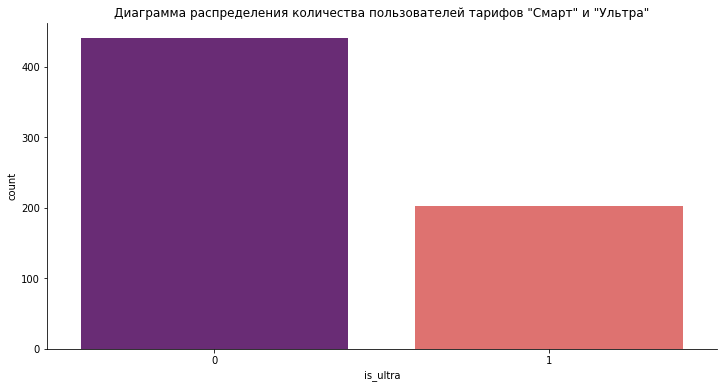

In [101]:
# графическое представление классового распределение целевого признака
data = pd.DataFrame({'is_ultra':target_test})
f, ax = plt.subplots(figsize=(12, 6))
sns.despine(f)
sns.countplot(data=data, x='is_ultra', palette='magma')
ax.set_title('Диаграмма распределения количества пользователей тарифов "Смарт" и "Ультра"')

In [97]:
# подсчёт доли единичных (тариф 'Ультра') значений
data.mean()

is_ultra    0.315708
dtype: float64

Если доля пользователей тарифа *Ультра* составляет около 32%, то доля пользователей тарифа *Смарт* составляет 68%, что совпадает со значением *accuracy* модели *DummyClassifier()*. Т.е. константная модель верна.

**Вывод:**

Значения *accuracy* модели *DummyClassifier()* ниже, чем у двух рассмотренных в проекте моделей, проверенных на тестовой выборке. Т.е. вероятность правильно угадать класс целевого признака ниже, чем вероятность предсказать класс с помощью сложных моделей, таких как *решающее дерево и случайный лес*. *Accuracy* модели *логистической регрессии* по результатам итоговой проверки не превышает *accuracy* константной модели, поэтому использовать данную модель нецелесообразно. Проверку на адкватность прошли модели *решающего дерева и случайного леса*.

### Шаг 6. Общий вывод

Наиболее подходящая по критериям модель машинного обучения — **модель случайного леса**, т.к. главным критерием выбора является показатель *accuracy* (доля правильных ответов), который у названной модели принимает максимальное значение среди остальных рассмотренных, а именно 81% на валидационной выборке. Среди рассмотренных моделей случайного леса лучшим показателем *accuracy* обладает модель с гиперпараметрами *n_estimators (количество деревьев)* = 40 и *max_depth (глубина дерева)* = 8. Выбранная модель прошла проверку на тестовой выборке с результатом в 80% метрики качества *accuracy*, также модель прошла проверку на адекватность.